In [1]:
!pip install openpyxl  --quiet
!pip install xlrd

     |████████████████████████████████| 96 kB 3.9 MB/s  eta 0:00:01


In [2]:
PATH = '/kaggle/input/utility-script'
import sys
sys.path.insert(1, PATH)
from script import *


In [3]:
import re
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


In [4]:
tf.__version__

'2.4.1'

In [5]:
df = pd.read_excel('../input/inshorts-news-data/Inshorts Cleaned Data.xlsx',engine='openpyxl')

print(df.shape)
df.head()

(55104, 5)


,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25


In [6]:
df['Source '].nunique()

1471

Text(0, 0.5, 'count()')

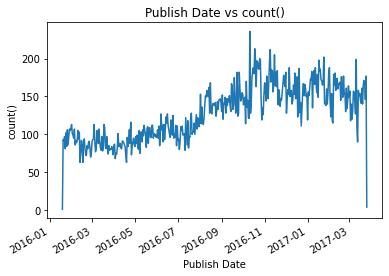

In [7]:
# @title Publish Date vs count()
temp = df['Publish Date'].value_counts()
temp.plot()
plt.title('Publish Date vs count()')
plt.xlabel('Publish Date')
plt.ylabel('count()')
## data for around 1 year 3 months
## count peaked at sep to nov 2016 , shows increasing trend overall

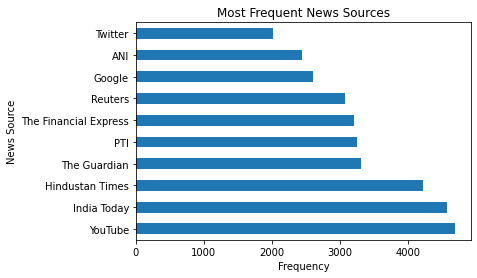

In [8]:
# @title Most Frequent News Sources
df['Source '].value_counts().head(10).plot(kind='barh')
plt.title('Most Frequent News Sources')
plt.xlabel('Frequency')
_ = plt.ylabel('News Source')

## around 1471 sources, on checking the top sources we have maximum contribution from Youtube

In [9]:
# @title Sentence length distribution
df['Headline_length'] = df['Headline'].apply(lambda x : len(x.split(' ')))
df['Short_length'] = df['Short'].apply(lambda x : len(x.split(' ')))
df[['Headline_length','Short_length']].describe()

## headline are mostly around 9 words long, shorts are around 60 words long
## using this reference for encoder and decoder len


,Headline_length,Short_length
count,55104.000000,55104.000000
mean,8.288110,58.316257
std,1.539975,2.423718
min,3.000000,40.000000
25%,7.000000,57.000000
50%,8.000000,59.000000
75%,9.000000,60.000000
max,14.000000,83.000000


<AxesSubplot:>

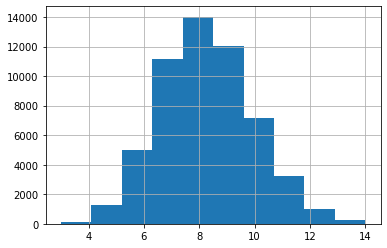

In [10]:
df['Headline_length'].hist()

<AxesSubplot:>

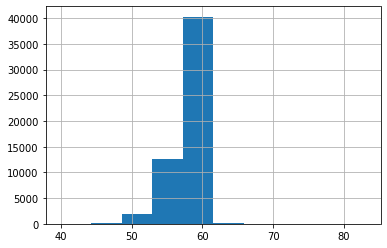

In [11]:
df['Short_length'].hist()

## Data Preprocessing


In [12]:
#@title Data Preprocessing
## Step1 Data Cleaning

def preprocess(text):
    text = '<SOS> ' + text + ' <EOS>'
    text = re.sub(r"&.[1-9]+;"," ",text) ## removing only html tags
    return text


article = df['Short']
summary = df['Headline']

article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

## 90%-10% division 
article_test = article[9000:10000]
summary_test = summary[9000:10000]

article = article[:9000]
summary = summary[:9000]

In [13]:
article_test.shape

(1000,)

In [14]:
article[0]

'<SOS> The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons. <EOS>'

In [15]:
summary[0]

'<SOS> 4 ex-bank officials booked for cheating bank of ₹209 crore <EOS>'

In [16]:
## Step2  Tokenising , padding
#  here we will be creating two tokenisers for summary and main news , while in language translation we created two tokenisers,
# here although the language is same but due different vocab distributions in summary and main news , will be having different token limits and
# it provides flexibility in terms of encoder decoder architecture also.

filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
## fitting on training data 
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)

## applying on training and test data
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

inputs_test = article_tokenizer.texts_to_sequences(article_test)
targets_test = summary_tokenizer.texts_to_sequences(summary_test)

In [17]:
# By adding 1 to the vocabulary size, we make space for special tokens,padding,etc.
# Even if we are not explicitly adding special tokens in the Tokenizer itself, 
#some layers in TensorFlow/Keras may assume the presence of a default padding token.

ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

## we can see considerable difference in the vocabulary size of article and summary , as expected

29825 12850


In [18]:
# these lengths are taken in reference to article and summary lengths.
ENCODER_LEN = 100
DECODER_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*8

In [19]:
#Step 3 - padding the sequences
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

inputs_test = tf.keras.preprocessing.sequence.pad_sequences(inputs_test, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets_test = tf.keras.preprocessing.sequence.pad_sequences(targets_test, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs_test = tf.cast(inputs_test, dtype=tf.int64)
targets_test = tf.cast(targets_test, dtype=tf.int64)

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_test = tf.data.Dataset.from_tensor_slices((inputs_test, targets_test)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model Training

In [21]:
num_layers = 5
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 80

In [22]:
# !rm -rf /kaggle/working/checkpoints

In [23]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [24]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [25]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(loss_object,tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))
    
@tf.function
def test_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
    loss = loss_function(loss_object,tar_real, predictions)


    test_loss(loss)
    test_accuracy(accuracy_function(tar_real, predictions))

In [26]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [27]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

    for (batch, (inp, tar)) in enumerate(dataset_test):
        test_step(inp, tar)
    
    if (epoch + 1) % 10 == 0:
        ckpt_save_path = ckpt_manager.save()
       
   
    print(f'Epoch {epoch + 1} Train Loss {train_loss.result():.4f} Train Accuracy {train_accuracy.result():.4f}')
    print(f'Epoch {epoch + 1} Test Loss {test_loss.result():.4f} Test Accuracy {test_accuracy.result():.4f}')
    
    print('\n')
  

Epoch 1 Train Loss 9.2849 Train Accuracy 0.0770
Epoch 1 Test Loss 9.0679 Test Accuracy 0.0951


Epoch 2 Train Loss 8.7127 Train Accuracy 0.0856
Epoch 2 Test Loss 8.3687 Test Accuracy 0.0951


Epoch 3 Train Loss 7.8977 Train Accuracy 0.0885
Epoch 3 Test Loss 7.6910 Test Accuracy 0.0950


Epoch 4 Train Loss 7.4174 Train Accuracy 0.0902
Epoch 4 Test Loss 7.5380 Test Accuracy 0.0984


Epoch 5 Train Loss 7.2638 Train Accuracy 0.0949
Epoch 5 Test Loss 7.4980 Test Accuracy 0.1020


Epoch 6 Train Loss 7.1206 Train Accuracy 0.0992
Epoch 6 Test Loss 7.4550 Test Accuracy 0.1050


Epoch 7 Train Loss 6.9389 Train Accuracy 0.1036
Epoch 7 Test Loss 7.4263 Test Accuracy 0.1085


Epoch 8 Train Loss 6.7314 Train Accuracy 0.1077
Epoch 8 Test Loss 7.3935 Test Accuracy 0.1112


Epoch 9 Train Loss 6.5206 Train Accuracy 0.1115
Epoch 9 Test Loss 7.3562 Test Accuracy 0.1133


Epoch 10 Train Loss 6.3084 Train Accuracy 0.1151
Epoch 10 Test Loss 7.3580 Test Accuracy 0.1150


Epoch 11 Train Loss 6.1035 Train Accur

## Model Evaluation

In [28]:
def summarize(input_article):
    summarized = evaluate(input_article,article_tokenizer,ENCODER_LEN,summary_tokenizer,DECODER_LEN,transformer)[0].numpy()
    summarized = np.expand_dims(summarized[:], 0)  
    return summary_tokenizer.sequences_to_texts(summarized)[0]

In [29]:
article[100]

'<SOS> Indian spinner Ravichandran Ashwin has broken the record for most wickets in a single Test season, taking his 79th this season during the Dharamsala Test against Australia on Saturday. Ashwin went past South African pacer Dale Steyn, who had claimed 78 wickets in 12 Tests in 2007-08. Ashwin has taken seven five-wicket hauls this season in 13 matches. <EOS>'

In [30]:
print("Actual Headline : ", summary[100],"\n Predicted Summary : ", summarize(article[100]))

Actual Headline :  <SOS> Ashwin breaks record for most wickets in a Test season <EOS> 
 Predicted Summary :  <sos> ashwin breaks 52 breaks 52 by the first ever test season


In [31]:
article[118]

'<SOS> Twenty-two-year-old jawan Roshan Kumar, who passed away in a road accident in Delhi last week, saved the lives of transplant patients by donating six of his vital organs. Roshan had suffered serious brain injuries in the accident.  Roshan is not at the border to protect the country. But... he served the nation by saving six lives,  said his uncle.  <EOS>'

In [32]:
print("Actual Headline : ", summary[118],"\nPredicted Summary : ", summarize(article[118]))

Actual Headline :  <SOS> Jawan killed in accident saves lives by donating 6 organs <EOS> 
Predicted Summary :  <sos> jawan killed in accident saves lives by donating 6 organs


In [40]:
article_test[9005]

'<SOS> After his recent extradition to the US, Mexican druglord Joaquin  El Chapo  Guzman is being held at New York s Metropolitan Correctional Center, described by an inmate as worse than Guantanamo Bay. Interestingly, two inmates had escaped from the maximum security prison in 1990. El Chapo was captured last year for the third time, after escaping top-security prisons twice. <EOS>'

In [41]:
print("Actual Headline : ", summary_test[9005],"\nPredicted Summary : ", summarize(article_test[9005]))

Actual Headline :  <SOS> 2 prisoners had escaped from jail holding druglord El Chapo <EOS> 
Predicted Summary :  <sos> madrid stars meet teen who guided rescuers to plane crash
